In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import *

## Define and Collect Trajectories of the Nonlinear System

In [87]:
def nonlinear_system(t,X,params):
    # define system parameters
    mu = params[0]
    lam = params[1]
    # specify rate of change of each state
    dx1dt = mu*X[0]
    dx2dt = lam*(X[1]-X[0]**4+2*X[0]**2)
    # roll up states into a numpy array
    dXdt = np.asarray([dx1dt,dx2dt])
    
    return dXdt

In [94]:
# initial condition
initial_state = [-3.5,2]
dt = 0.01
final_time = 100
t_vec = np.arange(0,final_time+dt,dt)
tspan = np.asarray([0,final_time])
mu = -0.05
lam = -1
params = np.asarray([mu,lam])

states = solve_ivp(nonlinear_system, tspan, initial_state, t_eval = t_vec, args = (params,))

t = states.t
x = states.y

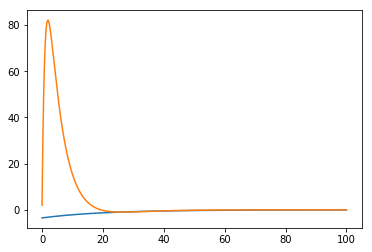

In [76]:
# plot trajectories
plt.plot(t,x[0,:],t,x[1,:])

## Perform DMD with and without Time Delay Embeddings and Visualize Mode Spectrum

In [77]:
def DMD(X,Xprime,r):
    ''' This function computes the linear approximation to a nonlinear dynamical system whose state 
    recordings are passed in.
    
    Arguments:
    
    Input:
    
        X: The states of the system
        
        Xprime: the rate of change of the states obtained form finite differencing or direct measurement
        
        r: the rank of the low-rank approximation
        
    Output:
    
        Phi: State transition matrix
        
        Lambda: Eigenvalues of Atilde
        
        b: Amplitude of the modes
    '''
    
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
    
    Lambda, W = np.linalg.eig(Atilde) # Step 3
    Lambda = np.diag(Lambda)
    
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    
    return Phi, Lambda, b

In [78]:
X = x[:,0:-1]
Xprime = x[:,1:]

# obtain DMD model
r = 4 # enter the value of r
Phi, Lambda, b = DMD(X[:,:],Xprime[:,:],r)
omega = np.log(np.diag(Lambda))/dt

In [79]:
# reconstruct dynamics with DMD as a sanity check

time_dynamics = np.zeros([2,len(t_vec)-1])

for i in range(time_dynamics.shape[1]):
    time_dynamics[:,i] = b*np.exp(omega*t_vec[i])
    
X_dmd = np.dot(Phi,time_dynamics)

Text(0, 0.5, 'Population')

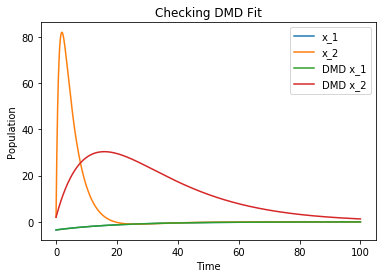

In [80]:
# plot to compare the DMD modes to the actual data
t = t_vec[:-1]
plt.plot(t,X[0,:],label='x_1')
plt.plot(t,X[1,:],label='x_2')
plt.plot(t,X_dmd[0,:],label='DMD x_1')
plt.plot(t,X_dmd[1,:],label='DMD x_2')
plt.legend()
plt.title("Checking DMD Fit")
plt.xlabel('Time')
plt.ylabel('Population')

(100, 9900)


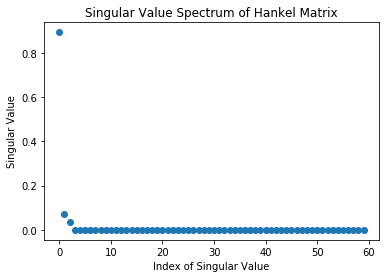

In [81]:
# time delay embedding

## Eigen-time delay coordinates
stackmax = 100 # Number of shift-stacked rows
r = 60  # rank of HAVOK model
num_states = 2
H = np.zeros((stackmax,X.shape[1]-stackmax))


for k in range(0,stackmax,num_states):
    H[k:k+2,:] = X[:,k:-(stackmax-k)]
  
U,S,VT = np.linalg.svd(H,full_matrices=0)
V = VT.T

S = S[:r]

plt.plot(S/np.sum(S),'o')
plt.title('Singular Value Spectrum of Hankel Matrix')
plt.ylabel('Singular Value')
plt.xlabel('Index of Singular Value')
print(H.shape)

In [84]:
latent_vars = np.where(S>1)[0]
print(latent_vars)
print(H.shape)

[0 1 2 3]
(100, 9900)


In [85]:
S

array([1.17723570e+04, 9.47450910e+02, 4.70606480e+02, 1.73081629e+00,
       5.18407022e-01, 2.23298634e-01, 5.95517120e-02, 2.74670174e-02,
       1.59495622e-02, 9.07699152e-03, 5.04325442e-03, 3.87988213e-03,
       2.47178260e-03, 1.71750814e-03, 1.47068400e-03, 9.53680729e-04,
       8.03370353e-04, 6.98090124e-04, 4.74975860e-04, 4.43203044e-04,
       3.57077585e-04, 2.84688113e-04, 2.65196166e-04, 2.15101615e-04,
       1.83669816e-04, 1.69684905e-04, 1.41024772e-04, 1.24741998e-04,
       1.14091359e-04, 9.75399318e-05, 8.86203501e-05, 7.93531675e-05,
       7.12712172e-05, 6.46773681e-05, 5.78323244e-05, 5.41473156e-05,
       4.81787032e-05, 4.50779019e-05, 4.23360541e-05, 3.80524536e-05,
       3.70775053e-05, 3.39951374e-05, 3.04129518e-05, 2.80486305e-05,
       2.52581636e-05, 2.36553018e-05, 2.16940973e-05, 2.05994052e-05,
       1.95033742e-05, 1.88809584e-05, 1.84333335e-05, 5.30331172e-07,
       1.98547605e-07, 3.30753044e-08, 1.28930123e-08, 5.69278568e-09,
      

In [52]:
# create the X and Xprime matrices of the dimelayed embeddings to pass to the DMD function
X_delay_prime = H[:,1:]
X_delay = H[:,:-1]

print(X_delay.shape,X_delay_prime.shape)
# obtain Time Delayed DMD model
r = 2 # enter the value of r
Phi_delay, Lambda_delay, b_delay = DMD(X_delay,X_delay_prime,r)
omega_delay = np.log(np.diag(Lambda_delay))/dt

print('Phi =',Phi_delay,'\n')
print('Lambda =',Lambda_delay,'\n')
print('b = ',b_delay,'\n')
print('Omega =',omega_delay)

(100, 99899) (100, 99899)
Phi = [[-0.00789723  0.0093931 ]
 [ 0.15776966 -0.20707211]
 [-0.00788934  0.00938371]
 [ 0.15700763 -0.20315501]
 [-0.00788145  0.00937433]
 [ 0.15624958 -0.19931319]
 [-0.00787357  0.00936496]
 [ 0.15549547 -0.19554518]
 [-0.0078657   0.0093556 ]
 [ 0.15474528 -0.19184953]
 [-0.00785784  0.00934625]
 [ 0.15399897 -0.18822481]
 [-0.00784999  0.00933691]
 [ 0.15325652 -0.18466963]
 [-0.00784214  0.00932758]
 [ 0.15251789 -0.18118262]
 [-0.0078343   0.00931825]
 [ 0.15178305 -0.17776245]
 [-0.00782647  0.00930894]
 [ 0.15105198 -0.17440781]
 [-0.00781865  0.00929963]
 [ 0.15032466 -0.17111741]
 [-0.00781084  0.00929034]
 [ 0.14960104 -0.16788998]
 [-0.00780303  0.00928105]
 [ 0.1488811  -0.1647243 ]
 [-0.00779523  0.00927178]
 [ 0.14816482 -0.16161914]
 [-0.00778744  0.00926251]
 [ 0.14745217 -0.15857336]
 [-0.00777966  0.00925325]
 [ 0.14674314 -0.15558581]
 [-0.00777188  0.009244  ]
 [ 0.14603769 -0.15265537]
 [-0.00776411  0.00923476]
 [ 0.14533581 -0.149780

In [53]:
# reconstruct dynamics with DMD as a sanity check

time_dynamics_delay = np.zeros([2,X_delay.shape[1]-1])

for i in range(time_dynamics_delay.shape[1]):
    time_dynamics_delay[:,i] = b_delay*np.exp(omega_delay*t_vec[i])
    
X_dmd_delay = np.dot(Phi_delay,time_dynamics_delay)

Text(0, 0.5, 'State')

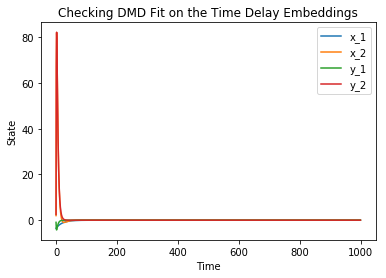

In [54]:
X_dmd_delay_model = X_dmd_delay[:,:]

# plot to compare the DMD modes to the actual data
end_delay = X_dmd_delay_model.shape[1]
t_delay = t[:end_delay]
plt.plot(t_delay,X[0,:end_delay],label='x_1')
plt.plot(t_delay,X[1,:end_delay],label='x_2')
plt.plot(t_delay,X_dmd_delay_model[0,:],label='y_1')
plt.plot(t_delay,X_dmd_delay_model[1,:],label='y_2')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')

## Compare against the Linearized System

In [15]:
def linear_system(t,Y,params):

    mu = params[0]
    lam = params[1]
    
    dy1dt = mu*Y[0]
    dy2dt = lam*Y[1]-lam*Y[2]
    dy3dt = 2*mu*Y[2]
    
    dYdt = np.asarray([dy1dt,dy2dt,dy3dt])
    
    return dYdt
    

In [16]:
def intrinsic_coords(x):
    y0 = x[0]
    y1 = x[1]
    y2 = x[0]**2
    
    y = np.asarray([y0,y1,y2])
    
    return y


In [17]:
initial_state_linear = intrinsic_coords(initial_state)

states_lin = solve_ivp(linear_system, tspan, initial_state_linear, t_eval = t_delay, args = (params,))

t_lin = states_lin.t
x_lin = states_lin.y

Text(0, 0.5, 'State')

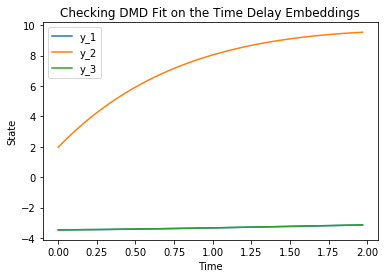

In [21]:
# plot to compare the DMD modes to the actual data
plt.plot(t_delay,X_dmd_delay_model[0,:],label='y_1')
plt.plot(t_delay,X_dmd_delay_model[1,:],label='y_2')
plt.plot(t_delay,X_dmd_delay_model[2,:],label='y_3')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')

Text(0, 0.5, 'State')

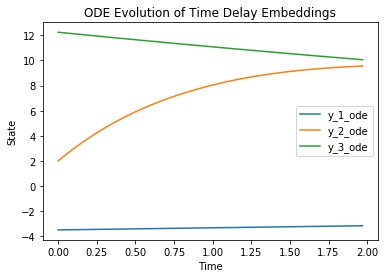

In [22]:
# plot to compare the DMD modes to the actual data
plt.plot(t_lin,x_lin[0,:],label='y_1_ode')
plt.plot(t_lin,x_lin[1,:],label='y_2_ode')
plt.plot(t_lin,x_lin[2,:],label='y_3_ode')
plt.legend()
plt.title("ODE Evolution of Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')

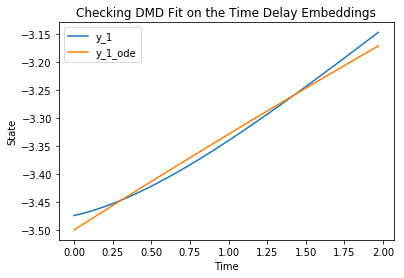

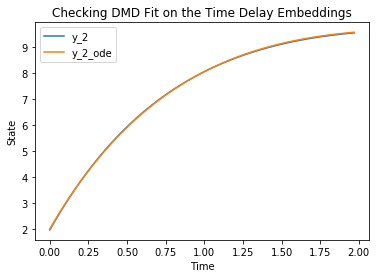

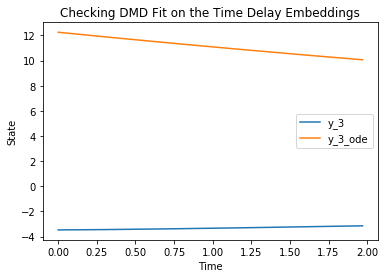

In [23]:
# plot to compare the DMD modes to the actual data
plt.plot(t_delay,X_dmd_delay_model[0,:],label='y_1')
plt.plot(t_lin,x_lin[0,:],label='y_1_ode')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')
plt.show()

plt.plot(t_delay,X_dmd_delay_model[1,:],label='y_2')
plt.plot(t_lin,x_lin[1,:],label='y_2_ode')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')
plt.show()

plt.plot(t_delay,X_dmd_delay_model[2,:],label='y_3')
plt.plot(t_lin,x_lin[2,:],label='y_3_ode')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')
plt.show()